In [63]:
import numpy as np
import sklearn as sl
from sklearn.ensemble import RandomForestClassifier

from sklearn import metrics
import pandas as pd

# za normalizaciju, standardizaciju
from sklearn import preprocessing

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

%matplotlib inline

# rad sa arff fajlovima
#import arff

# graficki prikaz
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

# 
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split

# Cross validation attempts to avoid overfitting while still 
# producing a prediction for each observation dataset.
from sklearn import model_selection
from sklearn.model_selection import cross_val_score

# Compute precision, recall, F-measure and support
# preciznost, odziv, F-mera, podrska

# ovi podaci se nalaze u sklearn.model_selection

# prognozirani pozitivni/negativni koji su zaista pozitivni od svih prognoziranih pozitivnih/negativnih 
# The precision is the ratio tp / (tp + fp) where tp is the number 
# of true positives and fp the number of false positives. 
# The precision is intuitively the ability of the classifier 
# to not label a sample as positive if it is negative

# odziv
# => prognozirani pozitivni/negativni koji su zaista pozitivni od ukupno pozitivnih/negativnih
# The recall is the ratio tp / (tp + fn) where tp is the number 
# of true positives and fn the number of false negatives. 
# The recall is intuitively the ability of the classifier to find all the positive samples

# The F-beta score can be interpreted as a weighted harmonic mean of the precision and recall, 
# where an F-beta score reaches its best value at 1 and worst score at 0

# The F-beta score weights the recall more than the precision by a factor of beta. 
# beta = 1.0 means recall and precision are equally important

# svi koji pripadaju datoj klasi
# The support is the number of occurrences of each class in y_test

from sklearn.metrics import classification_report

# ROC Curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# oversampling
from imblearn.over_sampling import SMOTE

from collections import Counter

# feature selection
# from sklearn.feature_selection import SelectPercentile, f_classif

from sklearn.ensemble import ExtraTreesClassifier

In [64]:
from arff2pandas import a2p
    
with open('JM1.arff') as f:
    df = a2p.load(f)

print(df.shape)

(10878, 22)


In [65]:
# uklanjamo instance koje imaju nedostajuce vrednosti
df = df.dropna()
print(df.shape)

(10878, 22)


In [66]:
type(df)

pandas.core.frame.DataFrame

In [67]:
df.columns

Index(['LOC_BLANK@NUMERIC', 'BRANCH_COUNT@NUMERIC',
       'LOC_CODE_AND_COMMENT@NUMERIC', 'LOC_COMMENTS@NUMERIC',
       'CYCLOMATIC_COMPLEXITY@NUMERIC', 'DESIGN_COMPLEXITY@NUMERIC',
       'ESSENTIAL_COMPLEXITY@NUMERIC', 'LOC_EXECUTABLE@NUMERIC',
       'HALSTEAD_CONTENT@NUMERIC', 'HALSTEAD_DIFFICULTY@NUMERIC',
       'HALSTEAD_EFFORT@NUMERIC', 'HALSTEAD_ERROR_EST@NUMERIC',
       'HALSTEAD_LENGTH@NUMERIC', 'HALSTEAD_LEVEL@NUMERIC',
       'HALSTEAD_PROG_TIME@NUMERIC', 'HALSTEAD_VOLUME@NUMERIC',
       'NUM_OPERANDS@NUMERIC', 'NUM_OPERATORS@NUMERIC',
       'NUM_UNIQUE_OPERANDS@NUMERIC', 'NUM_UNIQUE_OPERATORS@NUMERIC',
       'LOC_TOTAL@NUMERIC', 'Defective@{Y,N}'],
      dtype='object')

In [68]:
# df

In [69]:
df = df.drop(columns = ['CYCLOMATIC_COMPLEXITY@NUMERIC', 'DESIGN_COMPLEXITY@NUMERIC', 'ESSENTIAL_COMPLEXITY@NUMERIC', 'BRANCH_COUNT@NUMERIC'])

In [70]:
df.columns

Index(['LOC_BLANK@NUMERIC', 'LOC_CODE_AND_COMMENT@NUMERIC',
       'LOC_COMMENTS@NUMERIC', 'LOC_EXECUTABLE@NUMERIC',
       'HALSTEAD_CONTENT@NUMERIC', 'HALSTEAD_DIFFICULTY@NUMERIC',
       'HALSTEAD_EFFORT@NUMERIC', 'HALSTEAD_ERROR_EST@NUMERIC',
       'HALSTEAD_LENGTH@NUMERIC', 'HALSTEAD_LEVEL@NUMERIC',
       'HALSTEAD_PROG_TIME@NUMERIC', 'HALSTEAD_VOLUME@NUMERIC',
       'NUM_OPERANDS@NUMERIC', 'NUM_OPERATORS@NUMERIC',
       'NUM_UNIQUE_OPERANDS@NUMERIC', 'NUM_UNIQUE_OPERATORS@NUMERIC',
       'LOC_TOTAL@NUMERIC', 'Defective@{Y,N}'],
      dtype='object')

In [120]:
# df

In [125]:
df['LOC_TOTAL@NUMERIC'].min()

1.0

In [126]:
df['LOC_TOTAL@NUMERIC'].max()

3442.0

In [127]:
df['LOC_TOTAL@NUMERIC'].mean()

42.02767052767053

In [129]:
df['LOC_TOTAL@NUMERIC'].std()

76.61366965596302

In [130]:
df['LOC_TOTAL@NUMERIC'].median()

23.0

In [138]:
df['HALSTEAD_PROG_TIME@NUMERIC'].mean()

2047.355677514242

In [132]:
#sns.countplot(x='LOC_TOTAL@NUMERIC', data=df, palette='hls')
#plt.show()

In [72]:
df['Defective@{Y,N}'].value_counts()

N    8776
Y    2102
Name: Defective@{Y,N}, dtype: int64

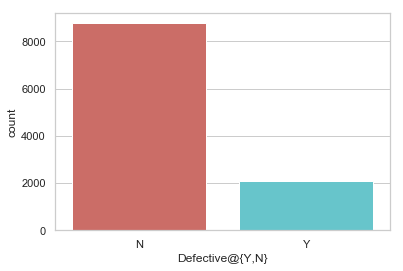

In [73]:
sns.countplot(x='Defective@{Y,N}', data=df, palette='hls')
plt.show()

In [74]:
# Grafik rasporedjenosti instanci po klasama pokazuje da postoji problem neravnomerne raspodele klasa instanci
# Posledica ove neravnomerne raspodele je da ce trenirani model dobro klasifikovati instance klase 'N', a lose
# klasifikovati instance cija je klasa 'Y'. 
# Medjutim, problem je u tome sto su instance od znacaja bas instance klase 'Y'
# Resenje ovog problema je over-sampling - dodavanje novih instanci koje pripadaju manje zastupljenoj klasi 'Y'
# Postoji vise metoda dodavanja novih instanci, a probacemo SMOTE


In [75]:
# kodiramo Y/N u 1/0
df['Defective@{Y,N}'] = pd.factorize(df['Defective@{Y,N}'])[0]

In [76]:
# ciljna kolona(defects@{false, true})
y_cols=['Defective@{Y,N}']

# lista atributa
X_cols=[i for i in df.columns if i not in y_cols]

In [77]:
X=df[X_cols]
y=df[y_cols]

In [78]:
type(y)

pandas.core.frame.DataFrame

In [79]:
np.set_printoptions(suppress='True')

In [80]:
#X

In [81]:
# potrebno je izvrsiti normalizaciju podataka kako atributi 
# sa visokim vrednostima ne bi previse uticali na rezultat klasifikacije 

# X = preprocessing.normalize(X)

scaler = preprocessing.StandardScaler().fit(X)


In [82]:
scaler.mean_

array([    4.62566648,     0.3707483 ,     2.73901452,    26.25767604,
          29.4440513 ,    14.17973433, 36852.40336551,     0.22460011,
         114.41220813,     0.13516547,  2047.35567751,   673.89566924,
          46.39731568,    68.12290862,    16.75473433,    11.17944475,
          42.02767053])

In [83]:
X = scaler.transform(X)

In [84]:
type(X)

numpy.ndarray

In [85]:
# type(X[0])

In [86]:
X

array([[ 3.44767987,  0.32972654,  0.36189414, ...,  3.75897224,
         4.06385466,  8.66689787],
       [44.36929914,  6.09370285, 17.11940989, ..., 22.20786688,
        14.31792952, 44.38018219],
       [-0.4639455 , -0.19427131, -0.30396741, ..., -0.62826489,
        -1.11295984, 14.18835959],
       ...,
       [ 0.53903537, -0.19427131, -0.19299049, ..., -0.06579859,
         0.67901441, -0.00036119],
       [-0.26334932, -0.19427131, -0.30396741, ..., -0.32828287,
        -0.21697271, -0.41806042],
       [-0.26334932,  0.32972654, -0.30396741, ..., -0.10329635,
         0.08168966, -0.30058251]])

In [87]:
#X[0]

In [88]:
y = y.values.ravel()

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [90]:
clf = RandomForestClassifier(random_state=0, n_estimators=100) # n_jobs=2, random_state=0, n_estimators=100)
clf.fit(X_train, np.ravel(y_train))
y_pred = clf.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))

0.8102022058823529


In [91]:
kfold = model_selection.KFold(n_splits=10, random_state=7)
modelCV = clf
scoring = 'accuracy'
results = model_selection.cross_val_score(modelCV, X, np.ravel(y), cv=kfold, scoring=scoring)
print("10-fold cross validation: ")
print("average accuracy: %.9f" % (results.mean()))
print("standard deviation: %.9f" % (results.std()))

10-fold cross validation: 
average accuracy: 0.774800872
standard deviation: 0.280608376


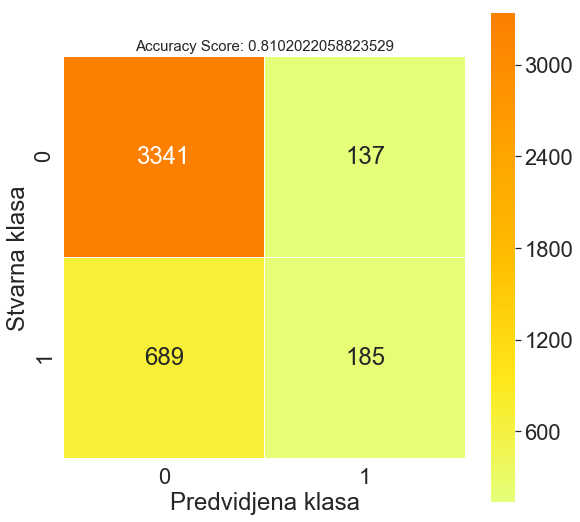

In [92]:
# matrica konfuzije
cm = metrics.confusion_matrix(y_test, y_pred)

plt.figure(figsize=(9,9))
sns.set(font_scale=2)
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Wistia');
plt.ylabel('Stvarna klasa');
plt.xlabel('Predvidjena klasa');
all_sample_title = 'Accuracy Score: {0}'.format(metrics.accuracy_score(y_test, y_pred))
plt.title(all_sample_title, size = 15);
figname = 'RF_basic_data_confussion_matrix.png'
plt.savefig(figname)
plt.show()

In [93]:
# preciznost, odziv, f-mera, podrska
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.96      0.89      3478
           1       0.57      0.21      0.31       874

   micro avg       0.81      0.81      0.81      4352
   macro avg       0.70      0.59      0.60      4352
weighted avg       0.78      0.81      0.77      4352



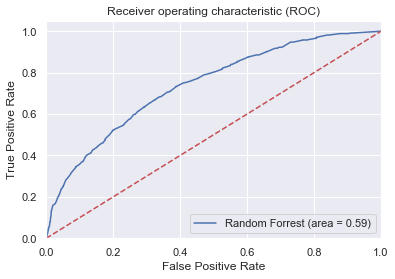

In [94]:
# The receiver operating characteristic (ROC) curve is 
# another common tool used with binary classifiers. 
# The dotted line represents the ROC curve of a purely 
# random classifier; a good classifier stays as far away 
# from that line as possible (toward the top-left corner)

logit_roc_auc = roc_auc_score(y_test, clf.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
plt.figure()
sns.set(font_scale=1)
plt.plot(fpr, tpr, label='Random Forrest (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)')
plt.legend(loc="lower right")
#plt.savefig('Log_ROC')
figname = 'RF_basic_data_ROC.png'
plt.savefig(figname)
plt.show()

In [95]:
# oversampling na osnovnim podacima, bez izbora atributa

In [96]:
X_resampled, y_resampled = SMOTE(kind="svm").fit_sample(X, y)

In [97]:
print(sorted(Counter(y_resampled).items()))

[(0, 8776), (1, 8776)]


In [98]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.4, random_state=42)

In [99]:
clf = RandomForestClassifier(random_state=0, n_estimators=100)
clf.fit(X_train, np.ravel(y_train))
y_pred = clf.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))

0.840051274747187


In [100]:
kfold = model_selection.KFold(n_splits=10, random_state=7)
modelCV = clf
scoring = 'accuracy'
results = model_selection.cross_val_score(modelCV, X_resampled, np.ravel(y_resampled), cv=kfold, scoring=scoring)
print("10-fold cross validation: ")
print("average accuracy: %.9f" % (results.mean()))
print("standard deviation: %.9f" % (results.std()))

10-fold cross validation: 
average accuracy: 0.834510478
standard deviation: 0.103669384


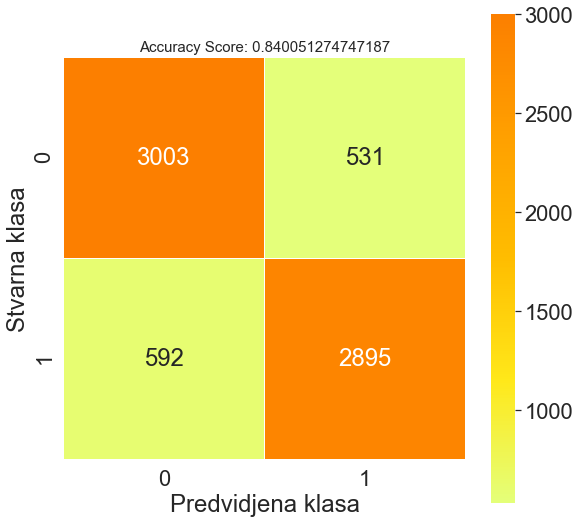

In [101]:
cm = metrics.confusion_matrix(y_test, y_pred)

plt.figure(figsize=(9,9))
sns.set(font_scale=2)
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Wistia');
plt.ylabel('Stvarna klasa');
plt.xlabel('Predvidjena klasa');
all_sample_title = 'Accuracy Score: {0}'.format(metrics.accuracy_score(y_test, y_pred))
plt.title(all_sample_title, size = 15);
figname = 'RF_oversampled_confussion_matrix.png'
plt.savefig(figname)
plt.show()

In [102]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.85      0.84      3534
           1       0.85      0.83      0.84      3487

   micro avg       0.84      0.84      0.84      7021
   macro avg       0.84      0.84      0.84      7021
weighted avg       0.84      0.84      0.84      7021



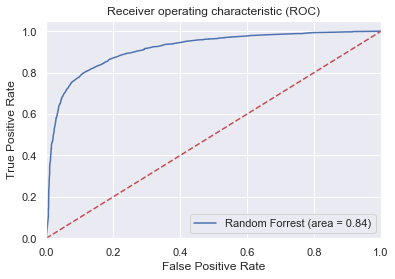

In [103]:
logit_roc_auc = roc_auc_score(y_test, clf.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
plt.figure()
sns.set(font_scale=1)
plt.plot(fpr, tpr, label='Random Forrest (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)')
plt.legend(loc="lower right")
#plt.savefig('Log_ROC')
figname = 'RF_oversampled_ROC.png'
plt.savefig(figname)
plt.show()

In [104]:
# pocetak izbora atributa

In [105]:
X_indices = np.arange(X.shape[-1])

In [106]:
# Univariate feature selection with F-test for feature scoring
# We use the default selection function: the 60% most significant features
#selector = SelectPercentile(f_classif, percentile=60)
#selector.fit(X, y)

selector = ExtraTreesClassifier(n_estimators=100)
selector.fit(X, y)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [107]:
print(selector.feature_importances_)

[0.06781373 0.03147672 0.04795073 0.06714616 0.05943807 0.05359736
 0.05174496 0.04682401 0.05761584 0.04748131 0.0510399  0.05681276
 0.06029996 0.06165258 0.0598431  0.05747592 0.12178689]


In [108]:
feature_importances = selector.feature_importances_

In [109]:
#scores = -np.log10(selector.pvalues_)
#scores /= scores.max()

<BarContainer object of 17 artists>

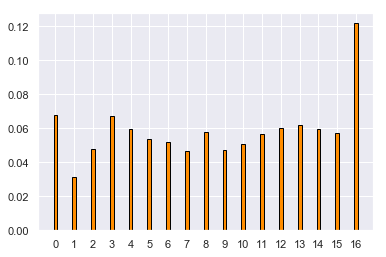

In [110]:
sns.set(font_scale=1)
plt.xticks(np.arange(0, len(X_indices)+1, 1.0))
plt.bar(X_indices , selector.feature_importances_, width=.2, label=r'ExtraTreesClasifier', color='darkorange',
        edgecolor='black')

In [111]:
df.columns

Index(['LOC_BLANK@NUMERIC', 'LOC_CODE_AND_COMMENT@NUMERIC',
       'LOC_COMMENTS@NUMERIC', 'LOC_EXECUTABLE@NUMERIC',
       'HALSTEAD_CONTENT@NUMERIC', 'HALSTEAD_DIFFICULTY@NUMERIC',
       'HALSTEAD_EFFORT@NUMERIC', 'HALSTEAD_ERROR_EST@NUMERIC',
       'HALSTEAD_LENGTH@NUMERIC', 'HALSTEAD_LEVEL@NUMERIC',
       'HALSTEAD_PROG_TIME@NUMERIC', 'HALSTEAD_VOLUME@NUMERIC',
       'NUM_OPERANDS@NUMERIC', 'NUM_OPERATORS@NUMERIC',
       'NUM_UNIQUE_OPERANDS@NUMERIC', 'NUM_UNIQUE_OPERATORS@NUMERIC',
       'LOC_TOTAL@NUMERIC', 'Defective@{Y,N}'],
      dtype='object')

In [112]:
df.columns[3]

'LOC_EXECUTABLE@NUMERIC'

In [113]:
df.columns[16]

'LOC_TOTAL@NUMERIC'

In [55]:
# scores[11]

In [56]:
#scores

In [57]:
#np.argpartition(scores, -1)

In [114]:
ind = np.argpartition(feature_importances, -10)[-10:]

In [115]:
ind

array([11, 15,  8,  4,  3, 12, 13, 14,  0, 16], dtype=int64)

In [116]:
# sortirani indeksi
sorted_ind = ind[np.argsort(feature_importances[ind])]

In [117]:
sorted_ind

array([11, 15,  8,  4, 14, 12, 13,  3,  0, 16], dtype=int64)

In [118]:
df.columns[sorted_ind]

Index(['HALSTEAD_VOLUME@NUMERIC', 'NUM_UNIQUE_OPERATORS@NUMERIC',
       'HALSTEAD_LENGTH@NUMERIC', 'HALSTEAD_CONTENT@NUMERIC',
       'NUM_UNIQUE_OPERANDS@NUMERIC', 'NUM_OPERANDS@NUMERIC',
       'NUM_OPERATORS@NUMERIC', 'LOC_EXECUTABLE@NUMERIC', 'LOC_BLANK@NUMERIC',
       'LOC_TOTAL@NUMERIC'],
      dtype='object')

In [59]:
type(X)

numpy.ndarray

In [60]:
to_remove = [a for a in X_indices if a not in ind] 

In [61]:
to_remove

[1, 2, 5, 6, 7, 9, 10]

In [62]:
#X_transformed = selector.transform(X)

# TODO: treba obrisati kontra od ind !!!
X_transformed = np.delete(X, to_remove, axis=1)

In [63]:
X_transformed[0]

array([ 3.44767987, 10.56178454,  2.47905561, 10.36876459,  9.96394289,
        7.34996544, 12.20895324,  3.75897224,  4.06385466,  8.66689787])

In [64]:
# kraj izbora atributa

In [65]:
# izbor atributa i oversampling

In [66]:
X_resampled, y_resampled = SMOTE(kind="svm").fit_sample(X_transformed, y)

In [67]:
X_resampled[0]

array([ 3.44767987, 10.56178454,  2.47905561, 10.36876459,  9.96394289,
        7.34996544, 12.20895324,  3.75897224,  4.06385466,  8.66689787])

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.4, random_state=42)

In [69]:
#X_train[0]

In [70]:
#X_test[0]

In [71]:
clf = RandomForestClassifier(random_state=0, n_estimators=100)
clf.fit(X_train, np.ravel(y_train))
y_pred = clf.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))

0.8541518302236148


In [72]:
kfold = model_selection.KFold(n_splits=10, random_state=7)
modelCV = clf
scoring = 'accuracy'
results = model_selection.cross_val_score(modelCV, X_resampled, np.ravel(y_resampled), cv=kfold, scoring=scoring)
print("10-fold cross validation: ")
print("average accuracy: %.9f" % (results.mean()))
print("standard deviation: %.9f" % (results.std()))

10-fold cross validation: 
average accuracy: 0.836961237
standard deviation: 0.116526312


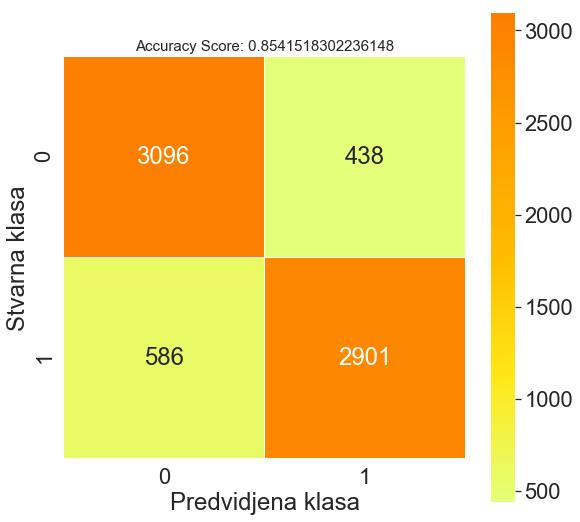

In [73]:
cm = metrics.confusion_matrix(y_test, y_pred)

plt.figure(figsize=(9,9))
sns.set(font_scale=2)
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Wistia');
plt.ylabel('Stvarna klasa');
plt.xlabel('Predvidjena klasa');
all_sample_title = 'Accuracy Score: {0}'.format(metrics.accuracy_score(y_test, y_pred))
plt.title(all_sample_title, size = 15);
figname = 'RF_feature_selection_oversampled_confussion_matrix.png'
plt.savefig(figname)
plt.show()

In [74]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.88      0.86      3534
           1       0.87      0.83      0.85      3487

   micro avg       0.85      0.85      0.85      7021
   macro avg       0.85      0.85      0.85      7021
weighted avg       0.85      0.85      0.85      7021



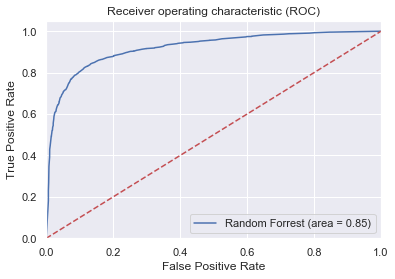

In [75]:
# The receiver operating characteristic (ROC) curve is 
# another common tool used with binary classifiers. 
# The dotted line represents the ROC curve of a purely 
# random classifier; a good classifier stays as far away 
# from that line as possible (toward the top-left corner)

logit_roc_auc = roc_auc_score(y_test, clf.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
plt.figure()
sns.set(font_scale=1)
plt.plot(fpr, tpr, label='Random Forrest (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)')
plt.legend(loc="lower right")
#plt.savefig('Log_ROC')
figname = 'RF_feature_selection_oversampled_ROC.png'
plt.savefig(figname)
plt.show()

In [76]:
#type(X_resampled)

In [77]:
X_resampled[0]

array([ 3.44767987, 10.56178454,  2.47905561, 10.36876459,  9.96394289,
        7.34996544, 12.20895324,  3.75897224,  4.06385466,  8.66689787])

In [78]:
# Konacan model nad svim podacima 

clf = RandomForestClassifier(random_state=0, n_estimators=100)
clf.fit(X_resampled, np.ravel(y_resampled))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [79]:
f = open("c_attributes.txt")

In [80]:
instances = f.readlines()

In [81]:
# instances

In [82]:
f.close()

In [83]:
predictions = []

In [84]:
#a = [1, 2, 3, 4, 5, 6]

In [85]:
#a = np.delete(a, [2, 4])
#print(a)

In [86]:
for i in instances:
    i = i.strip('\n')
    i = i.strip('\[')
    i = i.strip('\]')
    #i = np.array(i)
    #i = np.fromstring(i)
    i = np.array(i.split(','), dtype=float)
    # standardizacija
    i = scaler.transform(i.reshape(1, -1))
    #print(i[0])
    # izbor atributa
    # i = selector.transform(i.reshape(1, -1))
    i = np.delete(i, to_remove)
    #print(i[0])
    # rezultat predvidjanja se smesta u predictions
    predictions.append(clf.predict(i.reshape(1, -1))[0])

In [87]:
f = open("c_attributes_classes.txt")
classes = f.readlines()
f.close()

In [88]:
class_labels = []
for c in classes:
    class_labels.append(int(c.strip()))

In [89]:
class_labels[20:40]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [90]:
predictions[20:40]

[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [91]:
accuracy_score = metrics.accuracy_score(class_labels, predictions)

In [92]:
accuracy_score

0.6042031523642732

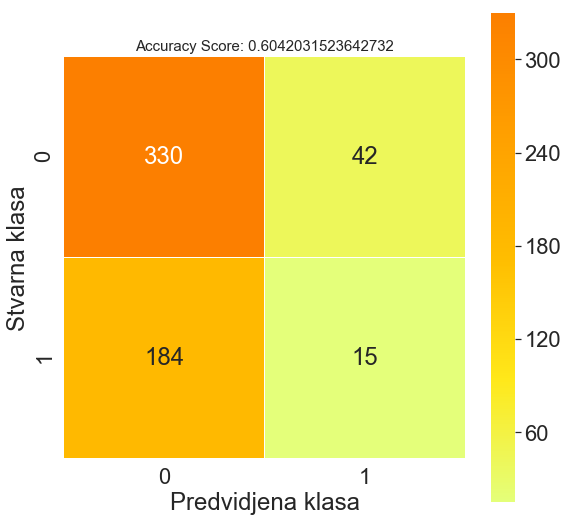

In [93]:
cm = metrics.confusion_matrix(class_labels, predictions)

plt.figure(figsize=(9,9))
sns.set(font_scale=2)
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Wistia');
plt.ylabel('Stvarna klasa');
plt.xlabel('Predvidjena klasa');
all_sample_title = 'Accuracy Score: {0}'.format(metrics.accuracy_score(class_labels, predictions))
plt.title(all_sample_title, size = 15);
figname = 'RF_c_files_confussion_matrix.png'
plt.savefig(figname)
plt.show()

In [94]:
# type(class_labels)

In [95]:
print(classification_report(class_labels, predictions))

              precision    recall  f1-score   support

           0       0.64      0.89      0.74       372
           1       0.26      0.08      0.12       199

   micro avg       0.60      0.60      0.60       571
   macro avg       0.45      0.48      0.43       571
weighted avg       0.51      0.60      0.53       571



In [96]:
from collections import Counter

In [97]:
Counter(class_labels)

Counter({0: 372, 1: 199})

In [98]:
Counter(predictions)

Counter({1: 57, 0: 514})

In [99]:
# X_train2, X_test2, y_train2, y_test2 = train_test_split(data, class_labels, test_size=0.4, random_state=42)

In [100]:
# X_train2.shape

In [101]:
indices_zeroes = []
indices_ones = []

In [102]:
for val in enumerate(class_labels):
    # print(val)
    if val[1] == 0:
        indices_zeroes.append(val[0])
    else:
        indices_ones.append(val[0])
    # print(val[0])

In [103]:
len(indices_ones)

199

In [104]:
len(indices_zeroes)

372

In [105]:
# indices_ones

In [106]:
# np.average(data[indices_ones][:,11])

In [107]:
# np.average(data[indices_zeroes][:,11])

In [108]:
# np.average(data[indices_ones][:,8])

In [109]:
# np.average(data[indices_zeroes][:,8])

In [110]:
# np.average(data[indices_ones][:,12])

In [111]:
# np.average(data[indices_zeroes][:,12])

In [112]:
# github_instance = np.array([8, 353, 14, 140, 1948361.3189646779, 336.5, 220617335959.33817, 218541.19461053805, 2722, 0.0029717682020802376, 12256518664.407677, 655623583.8316141, 1346, 1376, 144, 72, 361], dtype=float)
# github_instance = np.array([5, 37, 8, 5, 1050957.9486631174, 55.52127659574467, 3239695746.7548647, 19450.175652740458, 933, 0.01801111324008431, 179983097.04193693, 58350526.95822137, 614, 319, 94, 17, 42])
# github_instance = np.array([11, 261, 18, 107, 2031006.1313715037, 263.83941605839414, 141380850105.87363, 178619.82390402522, 2504, 0.0037901842527527253, 7854491672.548534, 535859471.7120757, 1364, 1140, 137, 53, 272], dtype=float)
# -------------------------------------
# github_instance = np.array([49, 211, 2, 103, 476426.1581724572, 284.29411764705884, 38506260620.376114, 45148.38475387226, 1390, 0.0035174839644113386, 2139236701.1320064, 135445154.2616168, 537, 853, 51, 54, 260], dtype=float)
# -------------------------------------------
# github_instance = np.array([10, 70, 6, 32, 575623.6626825822, 77.9375, 3496484281.5796075, 14954.223070107917, 827, 0.012830793905372895, 194249126.75442263, 44862669.21032375, 430, 397, 80, 29, 80], dtype=float)
# -------------------------------------------
# github_instance = np.array([3, 23, 6, 13, 462080.56114427367, 58.5974025974026, 1586625502.3403487, 9025.573557934904, 659, 0.017065602836879433, 88145861.24113049, 27076720.67380471, 376, 283, 77, 24, 26], dtype=float)
# github_instance = np.array([3, 34, 6, 13, 64905.57020861779, 130.0, 1096904136.5256405, 2812.574709040104, 435, 0.007692307692307693, 60939118.69586892, 8437724.127120312, 182, 253, 14, 20, 37], dtype=float)


# isnum # github_instance = np.array([2, 17, 6, 5, 3029.874609116446, 29.4, 2618902.417135891, 29.69277116934117, 57, 0.034013605442176874, 145494.57872977172, 89078.31350802351, 14, 43, 5, 21, 19], dtype=float)
# isalpha

# strcmp
# github_instance = np.array([2, 14, 6, 3, 1454.4023793190904, 15.75, 360782.6902198419, 7.635612491425225, 33, 0.06349206349206349, 20043.482789991216, 22906.837474275675, 9, 24, 4, 14, 16], dtype=float)

# putchar
# 
github_instance = np.array([2, 11, 6, 1, 24340.52014006465, 145.0, 511759435.9448593, 1176.4584734364582, 319, 0.006896551724137931, 28431079.774714407, 3529375.4203093746, 145, 174, 6, 12, 13], dtype=float)


In [113]:
github_instance

array([2.00000000e+00, 1.10000000e+01, 6.00000000e+00, 1.00000000e+00,
       2.43405201e+04, 1.45000000e+02, 5.11759436e+08, 1.17645847e+03,
       3.19000000e+02, 6.89655172e-03, 2.84310798e+07, 3.52937542e+06,
       1.45000000e+02, 1.74000000e+02, 6.00000000e+00, 1.20000000e+01,
       1.30000000e+01])

In [114]:
# github_instance = preprocessing.normalize(github_instance.reshape(1,-1))
github_instance = scaler.transform(github_instance.reshape(1, -1))

In [115]:
# github_instance = selector.transform(github_instance.reshape(1, -1))
github_instance = np.delete(github_instance, to_remove)

In [116]:
github_instance

array([  -0.26334932,   -0.42361157,  706.24995097,    0.81980703,
       1819.55509571,    0.98254296,    0.69877532,   -0.40327837,
          0.08168966,   -0.37890112])

In [117]:
prediction = clf.predict(github_instance.reshape(1,-1))

In [118]:
prediction

array([0], dtype=int64)